In [1]:
import glob
import os
import sys
import time
import uuid
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.vision.face.models import TrainingStatusType, Person

In [4]:
KEY = os.environ['COGNITIVE_SERVICE_KEY']
ENDPOINT = os.environ['ENDPOINT'] 

In [5]:
# Create an authenticated FaceClient.
face_client = FaceClient(ENDPOINT, CognitiveServicesCredentials(KEY))

In [6]:
#Test the case no cloaking applied
PERSON_GROUP_ID = 'imm_no_cloak_00'

# Used for the Snapshot and Delete Person Group examples.
TARGET_PERSON_GROUP_ID = str(uuid.uuid4()) # assign a random ID (or name it anything)

train_path = 'imm/train/'
ids = set([x.split('-')[0] for x in os.listdir(train_path)])
ids = list(ids)
ids.sort()

print('Person group:', PERSON_GROUP_ID)
face_client.person_group.create(person_group_id=PERSON_GROUP_ID, name=PERSON_GROUP_ID)

people = []
index_dict = []
for index in ids:
    person = face_client.person_group_person.create(PERSON_GROUP_ID, index)
    people.append(person)
    index_dict.extend([{'index': index, 'person_id': person.person_id}])

people_images = []
for index in ids:
    person_images = [train_path + file for file in os.listdir(train_path) if file.startswith(index)]
    people_images.append(person_images)

for person, person_images in zip(people, people_images):
    # Add to a woman person
    for image in person_images:
        w = open(image, 'r+b')
        face_client.person_group_person.add_face_from_stream(PERSON_GROUP_ID, person.person_id, w)

print()
print('Training the person group...')
# Train the person group
face_client.person_group.train(PERSON_GROUP_ID)

while (True):
    training_status = face_client.person_group.get_training_status(PERSON_GROUP_ID)
    print("Training status: {}.".format(training_status.status))
    print()
    if (training_status.status is TrainingStatusType.succeeded):
        break
    elif (training_status.status is TrainingStatusType.failed):
        sys.exit('Training the person group has failed.')
    time.sleep(5)
    
TEST_FOLDER = 'imm/test/'
test_images = os.listdir(TEST_FOLDER)
test_images.sort()
confidence_values_no_cloak = []
for test_image in test_images:
    # Get test image
    test_image_array = glob.glob(os.path.join(TEST_FOLDER, test_image))
    image = open(test_image_array[0], 'r+b')

    # Detect faces
    face_ids = []
    faces = face_client.face.detect_with_stream(image)
    for face in faces:
        face_ids.append(face.face_id)

    # Identify faces
    results = face_client.face.identify(face_ids, PERSON_GROUP_ID)
    print('Identifying faces in {}'.format(os.path.basename(image.name)))
    if not results:
        print('No person identified in the person group for faces from {}.'.format(os.path.basename(image.name)))
    else:
        for person in results:
            if not person.candidates:
                print('Cannot identify this identity')
            else:
                index_person = [d['index'] for d in index_dict if d['person_id']== person.candidates[0].person_id]
                if index_person[0] == os.path.basename(image.name).split('-')[0]:
                    print('Succesfull identifed with confidence: ', person.candidates[0].confidence)
                    confidence_values_no_cloak.append(person.candidates[0].confidence)
                else:
                    print('Identify wrong person')

Person group: imm_no_cloak_00

Training the person group...
Training status: running.

Training status: succeeded.

Identifying faces in 01-6m.jpg
Succesfull identifed with confidence:  0.91103
Identifying faces in 02-6m.jpg
Succesfull identifed with confidence:  0.94103
Identifying faces in 03-6m.jpg
Succesfull identifed with confidence:  0.89654
Identifying faces in 04-6m.jpg
Succesfull identifed with confidence:  0.87937
Identifying faces in 05-6m.jpg
Succesfull identifed with confidence:  0.93656
Identifying faces in 06-6m.jpg
Succesfull identifed with confidence:  0.94659
Identifying faces in 07-6m.jpg
Succesfull identifed with confidence:  0.87993
Identifying faces in 08-6f.jpg
Succesfull identifed with confidence:  0.86362
Identifying faces in 09-6m.jpg
Succesfull identifed with confidence:  0.87069
Identifying faces in 10-6m.jpg
Succesfull identifed with confidence:  0.92068
Identifying faces in 11-6m.jpg
Succesfull identifed with confidence:  0.87604
Identifying faces in 12-6f

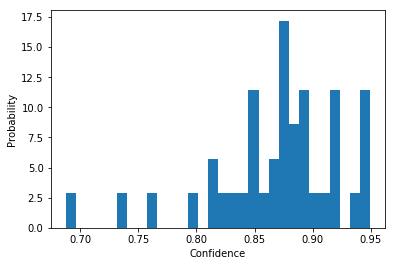

In [8]:
plt.hist(confidence_values_no_cloak, density=True, bins=30)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Confidence')
plt.savefig('confidence_hist_no_cloak.png')

In [ ]:
# Used in the Person Group Operations,  Snapshot Operations, and Delete Person Group examples.
# You can call list_person_groups to print a list of preexisting PersonGroups.
# SOURCE_PERSON_GROUP_ID should be all lowercase and alphanumeric. For example, 'mygroupname' (dashes are OK).
PERSON_GROUP_ID = 'imm_04'

# Used for the Snapshot and Delete Person Group examples.
TARGET_PERSON_GROUP_ID = str(uuid.uuid4()) # assign a random ID (or name it anything)

train_path = 'imm/train_min/'
ids = set([x.split('-')[0] for x in os.listdir(train_path)])
ids = list(ids)
ids.sort()

'''
Create the PersonGroup
'''
# Create empty Person Group. Person Group ID must be lower case, alphanumeric, and/or with '-', '_'.
print('Person group:', PERSON_GROUP_ID)
face_client.person_group.create(person_group_id=PERSON_GROUP_ID, name=PERSON_GROUP_ID)

people = []
index_dict = []
for index in ids:
    person = face_client.person_group_person.create(PERSON_GROUP_ID, index)
    people.append(person)
    index_dict.extend([{'index': index, 'person_id': person.person_id}])


'''
Detect faces and register to correct person
'''
# Find all jpeg images of person in working directory
people_images = []
for index in ids:
    person_images = [train_path + file for file in os.listdir(train_path) if file.startswith(index)]
    people_images.append(person_images)

for person, person_images in zip(people, people_images):
    # Add to a woman person
    for image in person_images:
        w = open(image, 'r+b')
        face_client.person_group_person.add_face_from_stream(PERSON_GROUP_ID, person.person_id, w)


'''
Train PersonGroup
'''
print()
print('Training the person group...')
# Train the person group
face_client.person_group.train(PERSON_GROUP_ID)

while (True):
    training_status = face_client.person_group.get_training_status(PERSON_GROUP_ID)
    print("Training status: {}.".format(training_status.status))
    print()
    if (training_status.status is TrainingStatusType.succeeded):
        break
    elif (training_status.status is TrainingStatusType.failed):
        sys.exit('Training the person group has failed.')
    time.sleep(5)

'''
Identify a face against a defined PersonGroup
'''
TEST_FOLDER = 'imm/test/'
test_images = os.listdir(TEST_FOLDER)
test_images.sort()
confidence_values = []
for test_image in test_images:
    # Get test image
    test_image_array = glob.glob(os.path.join(TEST_FOLDER, test_image))
    image = open(test_image_array[0], 'r+b')

    # Detect faces
    face_ids = []
    faces = face_client.face.detect_with_stream(image)
    for face in faces:
        face_ids.append(face.face_id)

    # Identify faces
    results = face_client.face.identify(face_ids, PERSON_GROUP_ID)
    print('Identifying faces in {}'.format(os.path.basename(image.name)))
    if not results:
        print('No person identified in the person group for faces from {}.'.format(os.path.basename(image.name)))
    else:
        for person in results:
            if not person.candidates:
                print('Cannot identify this identity')
            else:
                index_person = [d['index'] for d in index_dict if d['person_id']== person.candidates[0].person_id]
                if index_person[0] == os.path.basename(image.name).split('-')[0]:
                    print('Succesfull identifed with confidence: ', person.candidates[0].confidence)
                    confidence_values.append(person.candidates[0].confidence)
                else:
                    print('Identify wrong person')

Person group: imm_04


In [ ]:
plt.hist(confidence_values, density=True, bins=30)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Confidence')
plt.savefig('confidence_hist.png')
